<b> A complete guide: https://scikit-learn.org/stable/modules/clustering.html </b>

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [3]:
df = pd.read_csv(r"data\iris.csv",skipinitialspace=True)

In [4]:
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
cols = [col for col in df.columns if col != 'class']
X = df[cols].values

scaler = StandardScaler()
X_scal = scaler.fit_transform(X)

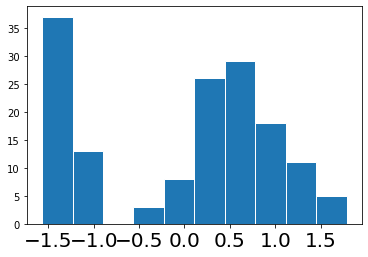

In [6]:
plt.hist(X_scal[:,2], edgecolor='white')

plt.xticks(fontsize=20)
plt.show()

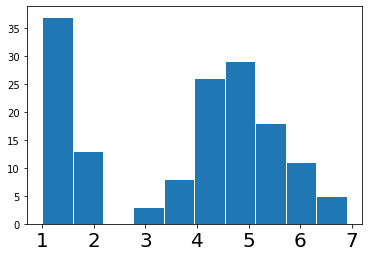

In [7]:
plt.hist(X[:,2], edgecolor='white')

plt.xticks(fontsize=20)
plt.show()

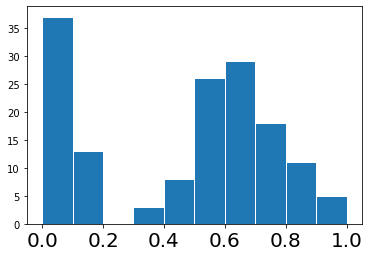

In [8]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

plt.hist(X_minmax[:,2], edgecolor='white')

plt.xticks(fontsize=20)
plt.show()

In [9]:
kmeans = KMeans( n_clusters=3, n_init=10, max_iter=100 )
kmeans.fit(X_minmax)

KMeans(max_iter=100, n_clusters=3)

In [10]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1])

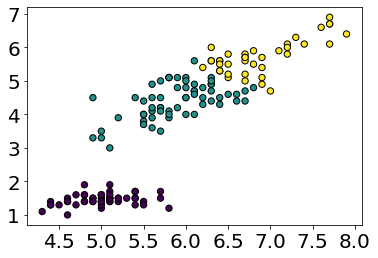

In [11]:
plt.scatter( X[:,0], X[:,2], s=40, edgecolor='black', c= kmeans.labels_ )

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

In [12]:
kmeans.cluster_centers_

array([[0.19611111, 0.595     , 0.07830508, 0.06083333],
       [0.44125683, 0.30737705, 0.57571548, 0.54918033],
       [0.70726496, 0.4508547 , 0.79704476, 0.82478632]])

In [13]:
centers = kmeans.cluster_centers_

In [14]:
centers = scaler.inverse_transform(centers)

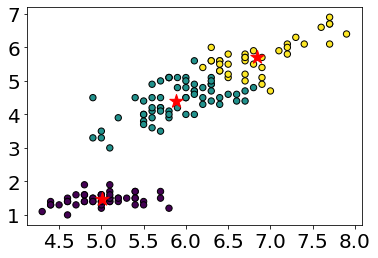

In [15]:
plt.scatter( X[:,0], X[:,2], s=40, edgecolor='black', c= kmeans.labels_ )
plt.scatter( centers[:,0], centers[:,2], c='red', marker='*', s=200 )

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

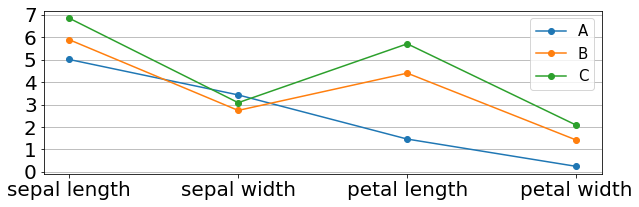

In [16]:
plt.figure(figsize=(10, 3))

clust_name = ['A', 'B', 'C']
for i in range(len(centers)):
    plt.plot(centers[i], marker='o', label=clust_name[i])
    
plt.xticks(range(0,len(cols)), cols, fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=15, loc='best')
plt.grid(axis='y')

[]

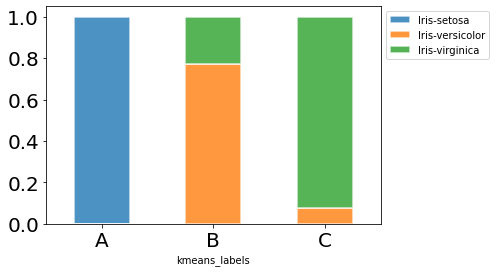

In [17]:
df['kmeans_labels'] = kmeans.labels_

bar_pl = df['class'].groupby(df['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)

plt.xticks(range(0, len(clust_name)), clust_name, fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

plt.plot()

In [18]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2]), array([50, 61, 39], dtype=int64))

In [19]:
print('SSE', kmeans.inertia_)
print('Silhouette', silhouette_score(X_minmax, kmeans.labels_))

SSE 6.982216473785234
Silhouette 0.5047687565398589


In [20]:
sse_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax)
    sse_list.append( kmeans.inertia_ )

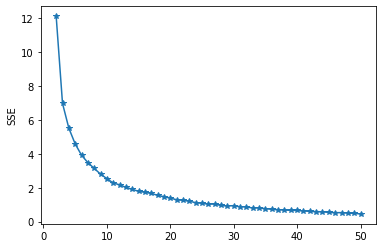

In [21]:
plt.plot(range(2, len(sse_list)+2), sse_list, marker='*')
plt.ylabel('SSE')
plt.show()

In [22]:
dbscan = DBSCAN( eps=0.3, min_samples=5)
dbscan.fit(X_minmax)

DBSCAN(eps=0.3)

In [23]:
dbscan.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int64)

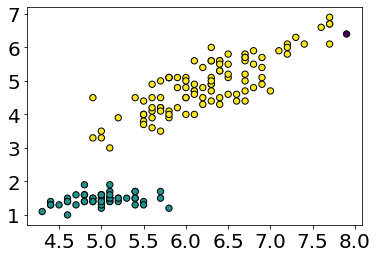

In [24]:
plt.scatter( X[:,0], X[:,2], s=40, edgecolor='black', c= dbscan.labels_ )

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

In [25]:
dist = pdist(X_minmax, 'euclidean')
dist = squareform(dist)

k=5
kth_distances = []
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

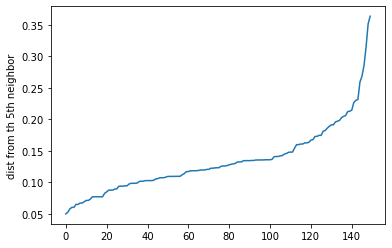

In [26]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from th 5th neighbor')
         
plt.show()

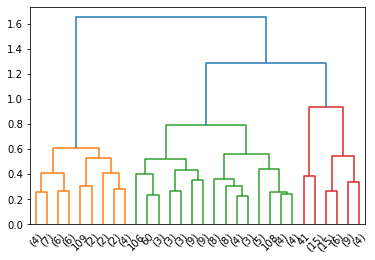

In [27]:
data_dist = pdist(X_minmax, metric='euclidean')
data_link = linkage(data_dist, method='complete')

res = dendrogram(data_link, truncate_mode='lastp')

In [28]:
hier = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')
hier.fit(X_minmax)

AgglomerativeClustering(linkage='single')

In [29]:
hier.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [30]:
hier = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='single')
hier.fit( dist )

AgglomerativeClustering(affinity='precomputed', linkage='single')